In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize as op
import pandas as pd
from scipy.stats import multivariate_normal
%matplotlib inline

Motter 2009 finds that if V4 receptive fields are plotted in the coordinates of V1 (roughly a log polar transform of visual space) then receptive fields are well described by a guassian surface with constant width (SD) with respect to eccentricity. If receptive fields are fit in visual space coordinates then the SD changes with eccentricity and the guassian surface fit is not good because the receptive fields are skewed away from the fovea. 

This suggests it is better to find RF profiles in the coordinates of V1 as the only parameter to estimate would be the center of the receptive field and thus our estimates would be more accurate. Even if we do estimate the size of the receptive field we would expect there to be less correlation between estimates of SD and receptive field position. 

Motter models V1 as a 3-d surface (football shaped) onto which visual space a 2-d surface is mappped.

The equations which Motter uses to perform this mapping from visual space to V1 takes:

$$v(\theta, w)\rightarrow c(r,z,\phi)$$

where $\theta$ is azimuth and $w$ eccentricity in visual space. $r$ is the radius of the football, $z$ is the distance measured through the football, and $\phi$ the angle looking head on at the point of the football.

The transform is as follows:

$$r= M(w) sin(w)$$

$$z=\int_0^w [M(w)^2-(\frac{dr}{dw})^2]^{0.5} dw$$

$$\phi=\theta$$

The function $M(w) \ (\frac{mm}{\text{deg}})$ is the cortical magnification factor which is the number of millimeters on cortex corresponding to a degree visual angle as a function of eccentricity.

The authors use the CMF for macaques takes from Levay et. al. (1985) in the paper written as:
$M(w)_a = 100(0.8 + w)^{-2}$ but this is for magnification in square mm per square degree visual angle so for the formula above we take the square root.
$$M(w) = 10(0.8 + w)^{-1}$$

From the formula we see $r$ and $z$ are purely a function of eccentricity $w$ and theta is a direct mapping.

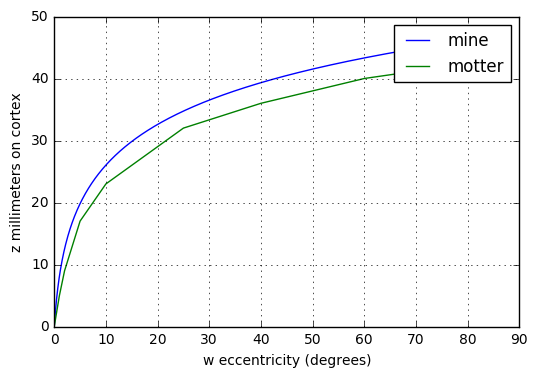

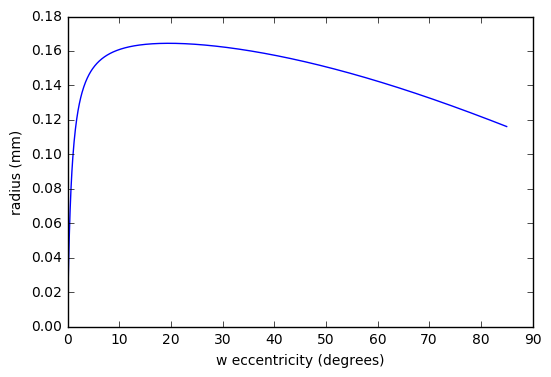

In [3]:
w = np.linspace(0,85,1000)
dw = w[1]-w[0]

a = 103 
b = 0.82 
x = 2.28

a = 100 
b = 0.8
x = 2

mw = np.sqrt(a/(b+w)**x)#had to change this to nine to get it to fit.

r = mw*np.sin(np.deg2rad(w))

drdw = np.gradient(r,dw)

z = integrate.cumtrapz((mw**2.-drdw**2.)**0.5, 
                          dx=dw, initial=0)

plt.plot(w,z);
plt.xlabel('w eccentricity (degrees)');
plt.ylabel('z millimeters on cortex');
plt.grid();


wm = [0, 1,2,5,10,15,25,40,60,85]
zm = [0, 5, 9, 17, 23, 26,32, 36,40, 43]
plt.plot(wm,zm);
plt.legend(['mine', 'motter']);
plt.figure()
plt.plot(w, r);
plt.xlabel('w eccentricity (degrees)');
plt.ylabel('radius (mm)')
plt.figure()
#plt.imshow(plt.imread('/Users/deanpospisil/Desktop/mot.png'));plt.xticks([]);plt.yticks([])

I am not sure why but mine seems to overshoot Motter's. I am going to move forward and build the fitting procedure around this mapping and the mapping can be fixed later.

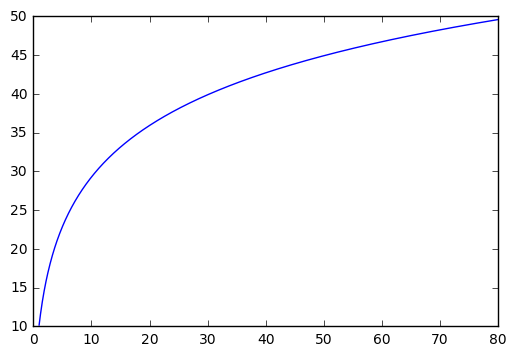

In [4]:
def v_to_c(x,y):
    winit = (x**2. + y**2.)**0.5
    
    w = np.linspace(0,winit,1000)
    dw = w[1]-w[0]
    mw = np.sqrt(100/(.8+w)**2)#had to change this to nine to get it to fit.

    r = mw*np.sin(np.deg2rad(w))

    drdw = np.gradient(r,dw)
 
    z = integrate.trapz((mw**2.-drdw**2.)**0.5, 
                              dx=dw)
    
    phi = np.arctan(y/x)
    x, y = np.array([np.cos(phi), np.sin(phi)])*r[-1]
    return x, y, z


y = np.linspace(1,80,1000);
x = y
xyz = np.array([v_to_c(ay,ay) for ax,ay in zip(x,y)]).squeeze()
plt.plot(y, xyz[:,-1])



In [5]:
import xarray as xr
import sys
import os 
import re

def get_ti_dat(i):
    topdir = '/loc6tb/data/responses/exp/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]

    fn = fns[i]

    a = re.findall('\d+',fn)[0]
    
    orig_fn = ('/loc6tb/data/responses/exp/rf_char_stim_exp/rf_char_stim_' 
    + a +'/')
    #print(orig_fn)
    fnss = [f for f in os.listdir(orig_fn) if '.nc' in f]     

    o = xr.open_dataset(orig_fn+fnss[0])
    rfx = (o.attrs['rfx']-600)/40.
    rfy = (o.attrs['rfy']-600)/40.
    sw = (o.attrs['stimWidth']-600)/40.

    da = xr.open_dataset(topdir + fn)['__xarray_dataarray_variable__']
    da.coords['ecc'] = da.coords['ecc'].values*sw
    da.coords['rot'] = da.coords['rot'].values*sw
    
    n_trial = len(da.dropna('trial', how='all').coords['trial'])

    #print((rfx**2+rfy**2)**0.5/40)
    if len(da.coords['unit'])>1:
        da = ((da)).sel(unit=1)
        m = da.mean('trial', skipna=True).squeeze()
        v = da.var('trial', skipna=True).squeeze()

        return m, v, rfx, rfy, n_trial, sw, o
    else:
        return None

def get_orig(i):
    topdir = '/loc6tb/data/responses/exp/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    
    fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]
    fn = fns[i]
    a = re.findall('\d+',fn)[0]
    
    orig_fn = ('/loc6tb/data/responses/exp/rf_char_stim_exp/rf_char_stim_' 
    + a +'/')
    #print(orig_fn)
    fnss = [f for f in os.listdir(orig_fn) if '.nc' in f]     

    o = xr.open_dataset(orig_fn+fnss[0])
    rfx = (o.attrs['rfx']-600)/40.
    rfy = (o.attrs['rfy']-600)/40.
    sw = (o.attrs['stimWidth']-600)/40.
    

    
    fn = fns[i]
    da = xr.open_dataset(topdir + fn)['__xarray_dataarray_variable__']
    da.coords['ecc'] = da.coords['ecc'].values*sw
    da.coords['rot'] = da.coords['rot'].values*sw
    return fn, da

In [7]:
topdir = '/loc6tb/data/responses/exp/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]
print(fns)


['ti_l181023DeansExp', 'ti_l181101DeansExp', 'ti_l181025DeansExp', 'ti_l181029DeansExp', 'ti_l181018DeansExp', 'ti_l181030DeansExp', 'ti_l181026DeansExp', 'ti_l181031DeansExp2', 'ti_l181024DeansExp', 'ti_l181030DeansExp2']


[70.]
[71.]
[43.]
[64.]
[18.]
[12.]


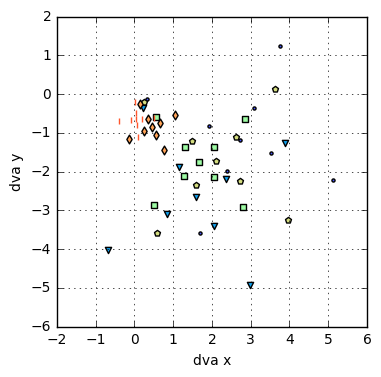

In [8]:
markers = ['', '.', 'v', '^', '1', 's', 'p', 'd', '|', '+', 'D']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
dats=[]
good_units = [1,2,5,6,7,8]
for i in good_units:
    m, v, rfx, rfy, n_trial, sw, o = get_ti_dat(i)
    #    print(sw)
    #    print(rfx)
    #    print(rfy)
    m = m.transpose('rot', 'ecc', 'stim')
    ms = []
    eccs = []
    rots = []
    resps=[]
    for r in m:
        for e in r:
            if sum(np.isnan(e.values))==0:
                resps.append(e.values)
                eccs.append(e.coords['ecc'].values)
                rots.append(e.coords['rot'].values)
    
    eccs = np.array(eccs)
    rots = np.array(rots)

    er = np.array([eccs,rots]).T
    theta = (np.arctan2(rfy, rfx))
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
    xy = np.array([np.dot(rot_mat, a_er) + np.array([rfx,rfy])
                   for a_er in er]).squeeze()  

 
    plt.scatter(xy[:,0], xy[:,1], c=colors[i], marker=markers[i]);plt.axis('square');
    plt.xlabel('dva x');
    plt.ylabel('dva y');
    dat = np.concatenate([xy,resps],1)[np.newaxis]
    dats.append(dat)
    print(np.array([sw])*40.)
plt.grid()

[[ 0.   -0.45]
 [ 0.   -0.15]
 [-0.45  0.  ]
 [-0.15  0.  ]
 [ 0.    0.  ]
 [ 0.15  0.  ]
 [ 0.45  0.  ]
 [ 0.    0.15]
 [ 0.    0.45]]
-85.60129464500447


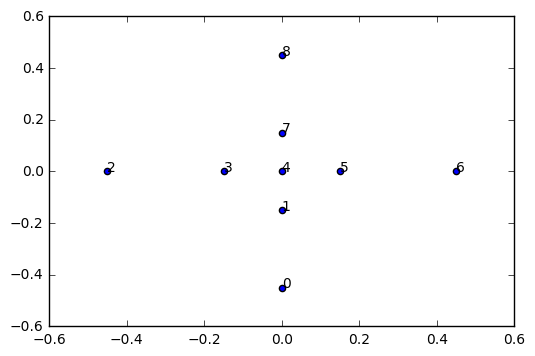

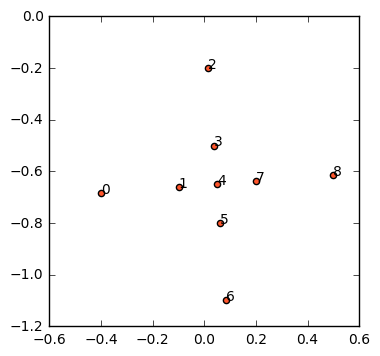

In [9]:
plt.scatter(eccs,rots)
for i in range(9):
    plt.text(eccs[i], rots[i], str(i));
er = np.array([eccs,rots]).T
print(er)
theta = (np.arctan2(rfy, rfx)) 
rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
xy = np.array([np.dot(rot_mat, a_er)+np.array([rfx,rfy])
               for a_er in er]).squeeze()  

plt.figure()
plt.scatter(xy[:,0], xy[:,1], c=colors[i]);plt.axis('square');
for i in range(9):
    plt.text(xy[i,0], xy[i,1], str(i));
    
print(np.rad2deg(theta))

/home/dean/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/dean/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


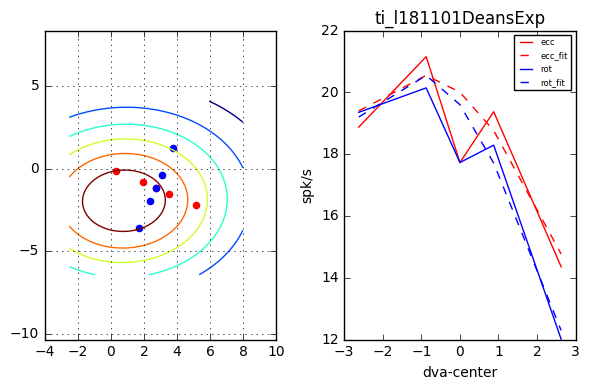

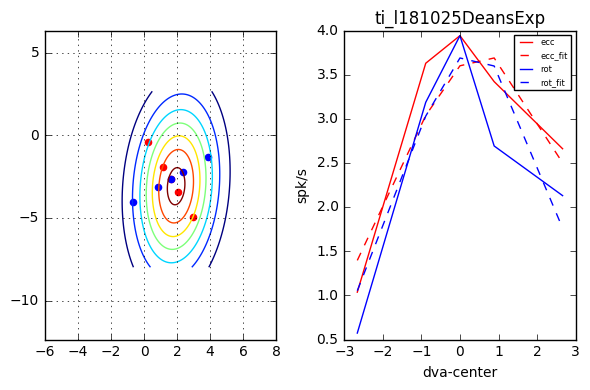

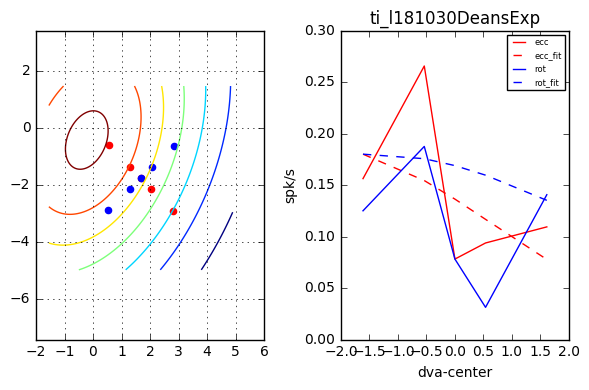

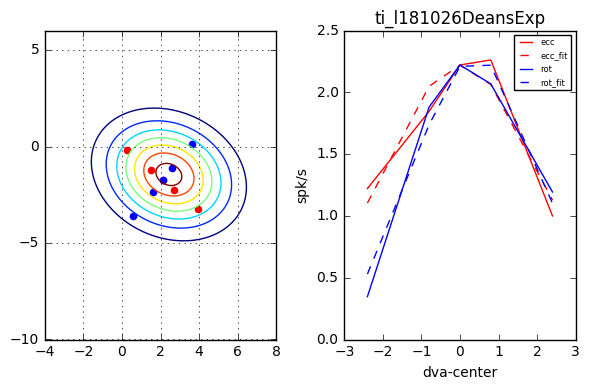

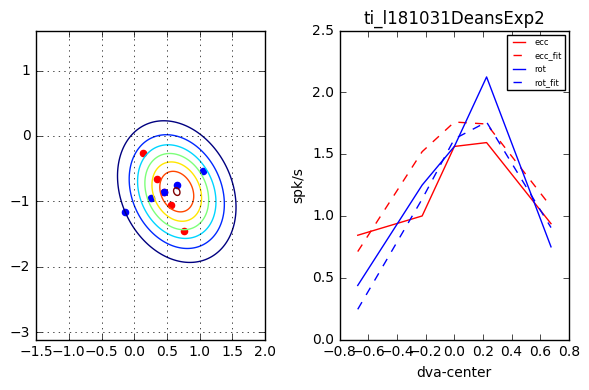

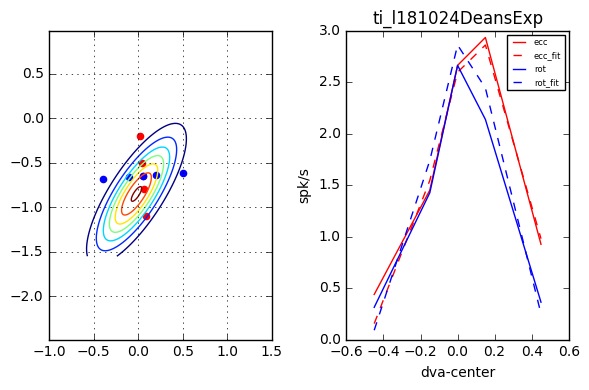

In [10]:
fits = []

rot_ind = np.array([0,1,4,7,8])
ecc_ind = np.array([2,3,4,5,6])

def gaussian2(pos, amp=1, mux=1, muy=1, varx=1, vary=1, r=0):
    #assume pos is n samps X 2
    #covxy=0
    
    resp = multivariate_normal([mux, muy], 
                                   [[varx, r*(varx*vary)**0.5], 
                                    [r*(varx*vary)**0.5, vary]]).pdf(pos)
    resp= resp/np.max(resp)
    resp = resp*amp 
    return resp

f= gaussian2

for i in range(len(dats)):
    dat = dats[i].squeeze()
    df = pd.DataFrame(dat, columns=['x', 'y',] + range(16))
    resp = df.iloc[:,2:]
    xy = df.iloc[:,:2].values

    resps = np.array(resps)
    width = np.linalg.norm(xy[2,] - xy[6])*1

    x = xy
    y = resp.mean(1)
    cx , cy = np.mean(x,0)
    amp_init = np.mean(y)
    sd = ((cx**2 + cy**2)**0.5)
    
    popt, pcov=  op.curve_fit(f, x, y, 
    bounds=([0, cx-width, cy-width, 0, 0,-1], 
            [np.inf, cx+width,  cy+width,  np.inf,  np.inf,1]),
                             p0=[amp_init, cx, cy, sd, sd, 0.3])

    fits.append(pd.DataFrame(np.round(popt,2), 
                       index=['amp', 'x', 'y', 'varx', 'vary', 'r' ]))
    

e_ind = np.array([])
for i in range(len(dats)):
    dat = dats[i].squeeze()
    df = pd.DataFrame(dat, columns=['x', 'y',] + range(16))
    resp = df.iloc[:,2:]
    xy = df.iloc[:,:2].values
    center = xy[4,:]
    width = np.linalg.norm(xy[2] - xy[6])

    fit = fits[i]
    amp, mux, muy, varx, vary, r = fit.values.squeeze()
    lims = varx+vary + r*(varx*vary)**0.5
    cbound = 0.1
    xi = np.linspace(center[0]-width, center[0]+width, 1000)
    yi = np.linspace(center[1]-width, center[1]+width, 1000)
    x, y = np.meshgrid(xi,yi)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    plt.figure()
    plt.subplot(121)
    resp_fit = gaussian2(pos, amp, mux, muy, varx, vary, r)
    plt.contour(x,y,resp_fit, );
    plt.scatter(xy[ecc_ind,0], xy[ecc_ind,1], color='r');plt.grid();
    plt.scatter(xy[rot_ind,0], xy[rot_ind,1], color='b');plt.grid();

    
    plt.axis('equal');
    plt.grid()
    plt.subplot(122)
    fn, da = get_orig(good_units[i])
    
    pos = xy[ecc_ind]
    resp_fit_ecc = gaussian2(pos, amp, mux, muy, varx, vary, r)
    plt.plot(da.coords['ecc'].values, 
             resp.mean(1).values[ecc_ind], color='r')
    plt.plot(da.coords['ecc'].values, resp_fit_ecc, color='r',
             linestyle='--')
    plt.title(fn)
    
    

    pos = xy[rot_ind]
    resp_fit_rot = gaussian2(pos, amp, mux, muy, varx, vary, r)
    plt.plot(da.coords['rot'].values, 
             resp.mean(1).values[rot_ind], color='b')
    plt.plot(da.coords['rot'].values, resp_fit_rot, color='b',
             linestyle='--')
    plt.ylabel('spk/s')
    plt.xlabel('dva-center')
    plt.legend(['ecc','ecc_fit', 'rot', 'rot_fit'], prop={'size': 6})
    plt.tight_layout()
    
    

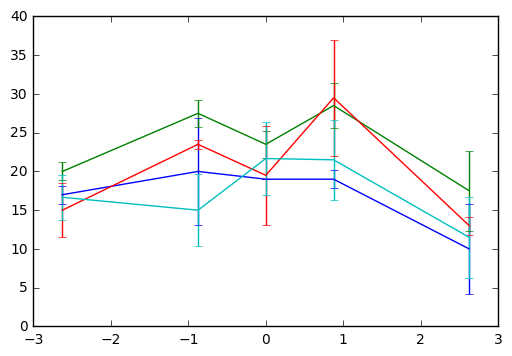

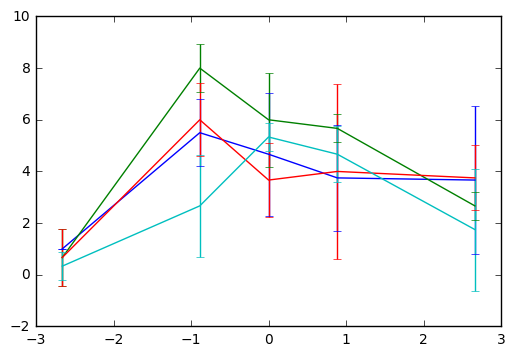

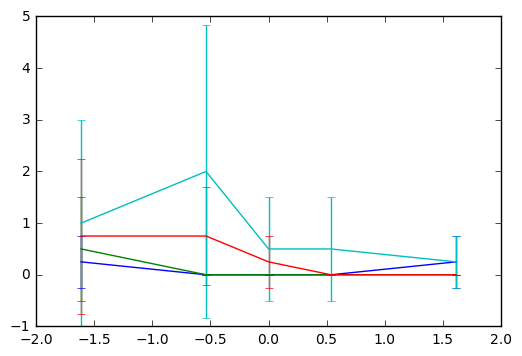

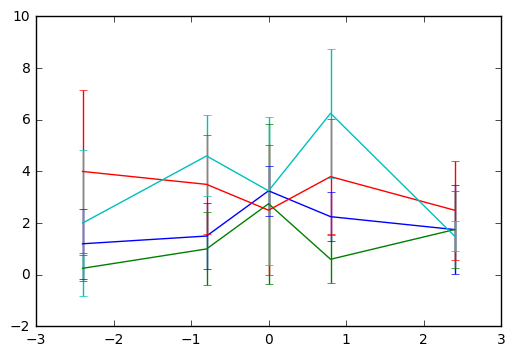

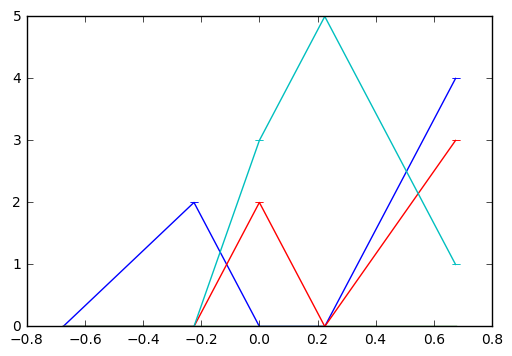

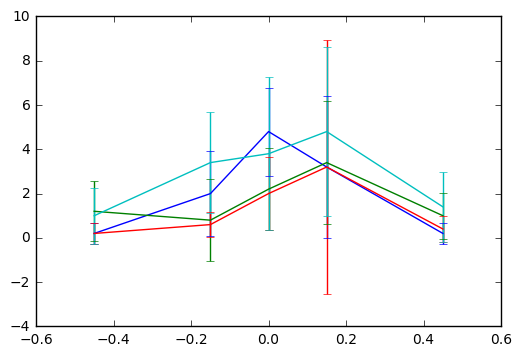

In [11]:
for j in good_units:
 
    m, v, rfx, rfy, n_trial, sw, o = get_ti_dat(j)
    plt.figure()
    m = m.sel(rot=0)
    v = v.sel(rot=0)
    #m.sel(stim=[14,15,]).plot.line(x='ecc')
    for i in [12, 13,14,15]:
        am = m.sel(stim=i).values
        av = v.sel(stim=i).values
        plt.errorbar(m.coords['ecc'], am, yerr=2*(av**0.5)/3**0.5)
    

In [13]:
v

<xarray.DataArray '__xarray_dataarray_variable__' (stim: 16, ecc: 5)>
array([[ 2.16    ,  1.2     ,  2.56    ,  9.44    ,  0.56    ],
       [ 0.64    ,  2.56    ,  3.6     ,  4.24    ,  0.64    ],
       [ 0.      ,  0.64    ,  2.      ,  3.44    ,  2.24    ],
       [ 0.16    ,  0.64    ,  4.16    ,  1.04    ,  0.24    ],
       [ 0.24    ,  0.      ,  0.96    , 13.2     ,  0.8     ],
       [ 0.      ,  0.16    ,  0.64    ,  6.16    ,  0.96    ],
       [ 0.16    , 12.96    ,  4.64    ,  1.76    ,  2.4     ],
       [ 0.      ,  3.04    ,  3.2     ,  2.222222,  0.64    ],
       [ 2.4     ,  3.84    ,  2.16    ,  1.36    ,  0.16    ],
       [ 0.24    ,  0.      ,  0.96    ,  2.56    ,  0.96    ],
       [ 0.24    ,  2.96    ,  2.56    , 10.24    ,  3.44    ],
       [ 0.      ,  3.76    ,  4.16    ,  2.64    ,  0.96    ],
       [ 0.16    ,  2.8     ,  2.96    ,  7.76    ,  0.16    ],
       [ 1.36    ,  2.56    ,  2.56    ,  5.84    ,  0.8     ],
       [ 0.16    ,  0.24    ,  2. 

One clear difficulty with this method is that it tends to overfit/be unstable. One way to get around this is to use a bayesian method where we put priors on the parameters. So for example we wouldn't expect the center of the  RF to be very far from the initial mapping (e.g. unlikely to be on the other side of fixation or where the last couple penetrations were, or not to be more than double what the RF formula would give). 

Our bayesian model will be:

$$R_i \sim NB[\mu=f(a, \mu_x, \mu_y, \sigma_x, \sigma_y, r \ | \ x_i, y_i), \alpha=\alpha)]$$

where

$$f=a \exp((\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu})^T )$$

a 2d gaussian with amplitude $a$, $\Sigma=  \begin{bmatrix} \sigma_x^2 & r \sigma_x \sigma_y  \\ r\sigma_x \sigma_y & \sigma_y^2  \\  \end{bmatrix}$, and $\vec{\mu}= \begin{bmatrix} \mu_x  \\ \mu_y \\  \end{bmatrix}$
   
$r$ here accounts for orientation of the RF, $\sigma$ for size, $\vec{\mu}$ for the center, and $a$ for the amplitude $\vec{x}$ is fixed and is the position of the stimulus.

So each response is a draw from a negative binomial with expected value according to this response surface and variability scaled by $\alpha$.

so for each of the parameters which generate these samples we have to put a prior on it. 

to a first approximation we will take the average SD of V4 as a function eccentricity in degrees to be:
$$2 E[\sigma] = 3+\frac{3}{4}e$$ with $e = |E[\vec{\mu}]|$ the distance of RF center from fovea.

when the experiment begins the experimenter will provide an estimate of the center of the RF based on handmapping we will take this as the mean of our prior on $\vec{\mu}$.
Then the mean on the prior for $\sigma$ will be $\frac{3+\frac{3}{4}|E[\vec{\mu}]|}{2}$

we will guess that roughly we at most expect RF's to be twice or half as large as this and we expect at most for the rf center to be one estimated RF width away.

so we have

$$\sigma_{xy} \sim \Gamma(loc=\frac{3+\frac{3}{4}|E[\vec{\mu}]|}{2},SD= \frac{3+\frac{3}{4}|E[\vec{\mu}]|}{4})$$

$$\vec{\mu} \sim N(loc=E[\vec{\mu}] ,SD= \frac{3+\frac{3}{4}|E[\vec{\mu}]|}{2}I_2)$$

we don't expect a huge amount of tilt in the receptive field but there could be some and we must be restricted to $(-1,1)$:

$$r \sim U(-.95, .95)$$

For amplitude we will take as a prior mean the estimated response rate at the estimated center of the receptive field
$$a ~  \Gamma(\text{loc}=\bar{X}, sd=s^2/\sqrt{n})$$

Finally for $\alpha$ eye balling a figure from Goris et al. but I should check on previously examined data.
$$ \alpha ~  \Gamma(\text{loc}=0.75, sd=1)$$

So now I have priors on all the data lets give this a try the date we will fit is for responses from a single unit for one stimuli in 1-d just to get a sense

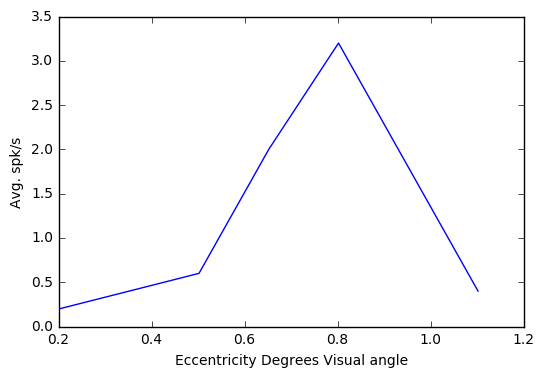

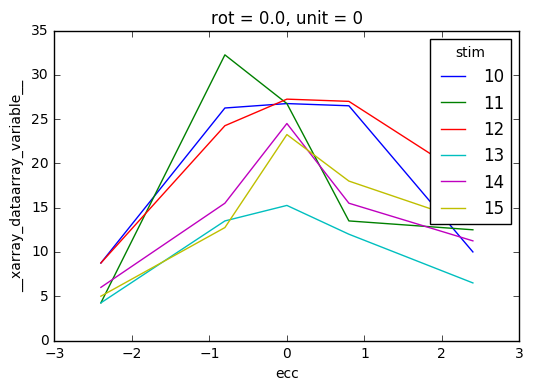

In [69]:
np.random.seed(12345)
dat = dats[-1].squeeze()
df = pd.DataFrame(dat, columns=['x', 'y',] + range(16))
resp = df.iloc[ecc_ind, -2]
xy = df.iloc[ecc_ind,:2].values
center = xy[4,:]
fn ,da = get_orig(6)
ecc = np.sum(xy**2, 1)**0.5
plt.plot(ecc, resp);plt.xlabel('Eccentricity Degrees Visual angle');plt.ylabel('Avg. spk/s')
plt.figure()
da.coords
da.sel(unit=0,rot=0, stim=[10,11,12,13,14,15]).dropna('trial', how='any').mean('trial').plot.line(x='ecc')

In [58]:
for i in good_units:
    
    print(i)
    print(da.sel(unit=0,ecc=0).dropna('trial', how='any').shape)

1
(16, 5, 2)
2
(16, 5, 3)
5
(16, 5, 4)
6
(16, 5, 4)
7
(16, 5, 1)
8
(16, 5, 5)


In [ ]:
def gaus(x, mu=0, sig=1, a=10):
    e = (-(x-mu)**2)/(2*sig**2)
    y = a*np.exp(e)
    return y

size=3
x = np.linspace(-2,2, size)
t_mu, t_sig, t_a, t_nsig = [1, 3, 10, 1]
y = gaus(x, mu=t_mu, sig=t_sig, a=t_a)


Y = np.random.poisson(y)*t_nsig

plt.plot(x,Y)


basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=0, sd=10)
    sig = pm.HalfNormal('sig', sd=5)
    a = pm.Normal('a', mu=1, sd=10)
    nsig = pm.HalfNormal('nsig', sd=10)
    
    
    rf = gaus(x, mu=mu, sig=sig, a=a)
    
    Y_obs = pm.NegativeBinomial('Y_obs', mu=rf, alpha=nsig,  observed=Y)

    # draw 500 posterior samples
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, tune=200, chains=4, njobs=1)
    

In [78]:
import torch
import torchvision.models as models

In [80]:
mod = models.vgg11(pretrained=True).features.cuda().eval()


AssertionError: 
The NVIDIA driver on your system is too old (found version 8000).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

ImportError: No module named caffe